In [1]:
# python code for solving the TDSE using Cayley's operator
# Copyright (C) 2022  Ankit Kumar
# Email: akvyas1995@gmail.com
#-----------------------------------------------------------------------
#
# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 2
# of the License, or (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with this program; if not, write to the Free Software
# Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
#
#-----------------------------------------------------------------------


import numpy as np
from math import pi
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.sparse import spdiags
from scipy.sparse.linalg import splu
from findiff import FinDiff

plt.style.use('vyason')
def_width,def_height = plt.rcParams["figure.figsize"]

In [2]:


# 2nd order derivative (3pt central difference)
#-----------------------------------------------------------------------
def diff2(f,h,J):
    d2f=(np.roll(f,-1)+np.roll(f,+1)-2*f)/h**2
    d2f[0]=d2f[J-1]=0
    return d2f

# LU matrix on the left: tridiagonal case
#-----------------------------------------------------------------------
def lhs_lumatrix(J,dx,dt,V,hb,hb2m):
    a = 1 + 1j*dt*(2*hb2m/dx**2 + V)/(2*hb)
    b = (-1j*hb2m*dt/(2*hb*dx**2))*np.ones((J),float)
    return splu(spdiags(np.array([b,a,b]),np.array([-1,0,+1]),J,J).tocsc())

# zeta vector on the right: tridiagonal case
#-----------------------------------------------------------------------
def zeta(J,psi,dx,dt,V,hb,hb2m):
    return psi - 1j*(dt/hb)*(-hb2m*diff2(psi,dx,J)+V*psi)/2

In [3]:


hb = 1                                  #Planck's constant, hbar
m =	1                                   #mass of particle, m


# defining the system for particle in a box
#-----------------------------------------------------------------------

xmin,xmax,dx = -10,+10,0.01             #x-limits of simulation box
x = np.arange(xmin,xmax+dx,dx)          #defining the position grid
J = len(x)                              #dimension of position grid

V = np.zeros(J,float)                     #zero potential
V[0],V[J-1] = np.tan(pi/2),np.tan(pi/2)             #infinite potential at the boundaries

x0,p0,sig = 0,1,1                       #initial position,momentum, position spread

psi = np.exp( -((x-x0)/(2*sig))**2 + 1j*p0*(x-x0) )/np.sqrt( sig*np.sqrt(2*pi) )

tmax,dt,plot_steps = 1600,0.01,10        #time limit, time step, and interval b/w 2 successive plots

d_dx = FinDiff(0, dx, 1, acc=4)

In [4]:


# solving the TDSE
#-----------------------------------------------------------------------

hb2m = hb**2/(2*m)                                          #value of hbar^2/2m
lhs_lu = lhs_lumatrix(J,dx,dt,V,hb,hb2m)	                #LU decomposition for the LHS matrix

ls_time = []
ls_pos = []
ls_mom = []

t = 0
ymax = 1.01*np.max(np.abs(psi)**2)
while t < tmax:

    pos = simps( x*np.abs(psi)**2 , dx=dx ) 
    mom = -1j*hb* simps( np.conj(psi)*d_dx(psi), dx=dx )
    ls_time.append(t)
    ls_pos.append(pos)
    ls_mom.append(mom.real)

    for j in range(plot_steps):                             #evolve plot_steps times
        psi = lhs_lu.solve(zeta(J,psi,dx,dt,V,hb,hb2m))   
    t = t + plot_steps*dt

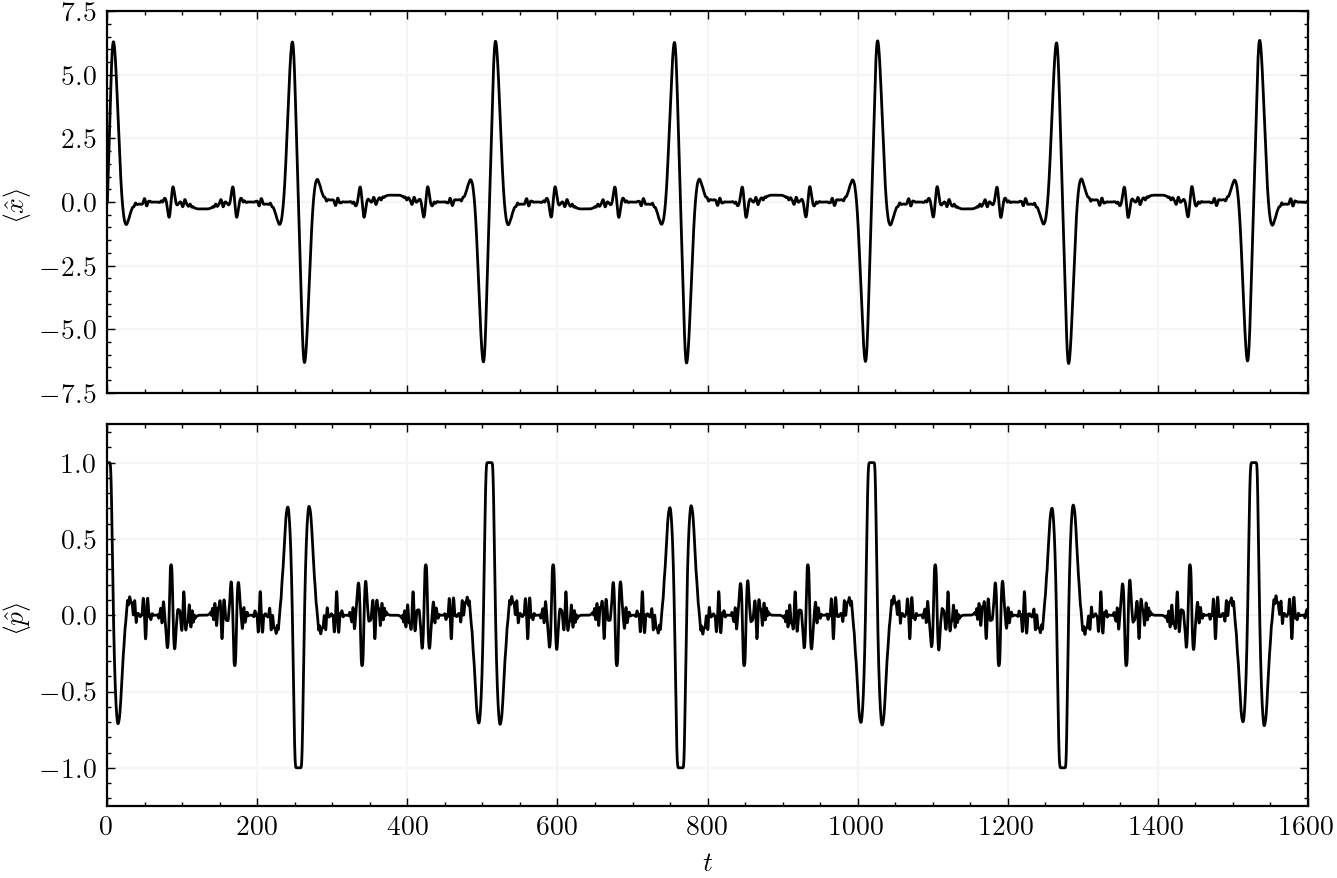

In [5]:
fig = plt.figure(constrained_layout=True,dpi=200)
fig.set_size_inches(2*def_width,2*def_height)
ax = fig.add_gridspec(2,1).subplots(sharex=True)

ax[0].plot(ls_time,ls_pos,c='black',lw=1)
ax[1].plot(ls_time,ls_mom,c='black',lw=1)

ax[1].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$\ev{\hat x}$')
ax[1].set_ylabel(r'$\ev{\hat p}$')

ax[0].set_xlim(0,tmax)
ax[0].set_ylim(-7.5,+7.5)
ax[1].set_ylim(-1.25,+1.25)

ax[0].grid()
ax[1].grid()

fig.savefig('heartbeat_in_a_box.pdf')